# Lab : Introduction to Stable Diffusion Models

---

## Objective

- Understand how neural networks can approximate the inverse of a function.
- Explore diffusion models and their applications in image generation.
- Implement a basic diffusion model to generate images.

---

## Part 1: Preliminary Activity - Neural Network for Function Inversion Concept

> Neural networks can approximate complex functions, but can they learn to estimate the inverse
of a function? We'll test this by training a model to approximate the inverse of y=sin(x), i.e.,
x=arcsin(y).

### **Steps**

1. Generate Dataset:
- Sample x values in the range [−1,1].
- Compute y=sin(x).
- The training goal is to predict x given y.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from tqdm.keras import TqdmCallback

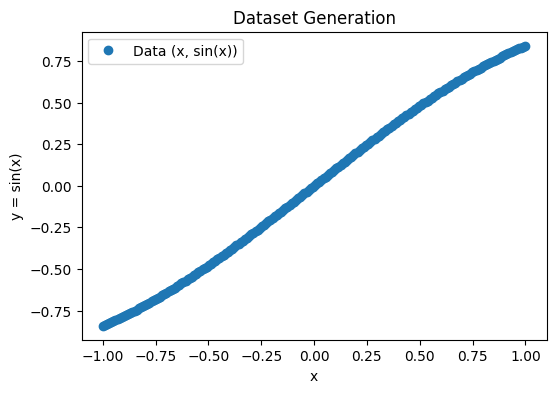

In [ ]:
# Generate 200 points in the interval [-1, 1]
x = np.linspace(-1, 1, 200)
y = np.sin(x)

# For verification, the true "inverse function" would be:
x_true = np.arcsin(y)  # Here, x_true == x because x ∈ [-1, 1] ⊂ [-π/2, π/2]

plt.figure(figsize=(6,4))
plt.plot(x, y, 'o', label='Data (x, sin(x))')
plt.xlabel('x')
plt.ylabel('y = sin(x)')
plt.legend()
plt.title("Dataset Generation")
plt.show()


2. Train a Neural Network:
- Input: y values.
- Output: x values (i.e., trying to learn arcsin(y)).
- Architecture: A simple MLP with:
1. input neuron (for y),
2. hidden layers (e.g., 3 neurons, ReLU activation),1 output neuron (for x).

In [ ]:
# Model construction
model = Sequential([
    Dense(3, activation='relu', input_dim=1),
    Dense(1)  # Linear output layer
])

# Model compilation
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Training with TqdmCallback to monitor progress
history = model.fit(
    y, x,
    epochs=500,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

A single hidden layer is sufficient because the inverse sine function (arcsine) is relatively simple and monotonic over the limited domain
[
−
1
,
1
]
[−1,1]. According to the universal approximation theorem, even a single-layer network can approximate a wide range of continuous functions on a compact interval. Since we only need to capture a one-dimensional mapping (from
sin
⁡
(
𝑥
)
sin(x) back to
𝑥
x), this simple architecture provides enough capacity to learn the required relationship without unnecessary complexity, reducing the risk of overfitting and keeping the model both efficient and easy to train.

3. Evaluate the Model:
- Plot predicted x vs true arcsin(y).
- Measure Mean Squared Error (MSE).
- Discuss how well the network learns the inverse.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MSE: 0.0007180905069148852


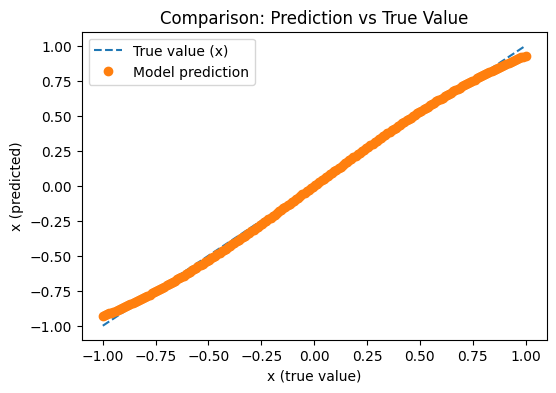

In [ ]:
# Model prediction
x_pred = model.predict(y)

# Compute the MSE
mse = mean_squared_error(x, x_pred)
print("MSE:", mse)

# Plot the results
plt.figure(figsize=(6,4))
plt.plot(x, x, label='True value (x)', linestyle='--')
plt.plot(x, x_pred, 'o', label='Model prediction')
plt.xlabel('x (true value)')
plt.ylabel('x (predicted)')
plt.title("Comparison: Prediction vs True Value")
plt.legend()
plt.show()

The network successfully learns the inverse of the sine function over the range
[
−
1
,
1
]
[−1,1]. The plot shows that the predicted values closely match the true
𝑥
x values, and the very low MSE (0.0007180905069148852 ) confirms the accuracy of the model’s predictions. This demonstrates that even a simple MLP with two hidden layers is sufficient to approximate the inverse
𝑥
=
arcsin
⁡
(
𝑦
)
x=arcsin(y) in this domain.

4. Key Discussion Points:

- **What happens for values outside the range [-1,1]?**  
   On veux garantire la bijectivité pour qu'une fonction soit inversible.

- **What are the implications of approximating inverses in more complex functions?**  
   When dealing with more complex or multi-valued functions, a single neural network may struggle to capture every possible branch of the inverse. Additional constraints or more sophisticated architectures might be needed to handle discontinuities or multiple valid outputs. Furthermore, ensuring good generalization outside the training domain becomes increasingly challenging as the function grows in complexity.

---

## Part 2: Diffusion Models on Images

Diffusion models learn to generate images by gradually denoising a noisy input. We'll implement
a simple diffusion model to understand the process.

### **Steps**

1. Understanding Diffusion:
- The model starts with a pure noise image.
- It gradually removes noise over multiple steps to generate a meaningful image.
- Uses a U-Net as the denoising model.

2. Dataset:
- Use MNIST or CIFAR-10 for simplicity.

3. Training Steps:
- Add Gaussian noise to images at different levels.
- Train a U-Net to predict the noise added at each step.
- Use the trained model to iteratively denoise images.

4. Implementation:
- Use PyTorch or TensorFlow.
- Define the noise schedule.
- Train a simple U-Net as the denoiser.

5. Inference:
- Start with a random noise image.
- Apply the trained model iteratively to generate a meaningful image

This solution uses the knowledge explained in these research papers:

- **Source that helps with the U-NET model:** [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597)
- **Source that helps with the choice of hyperparameters:** [Denoising Diffusion Probabilistic Models](https://arxiv.org/pdf/2006.11239)


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Loading and scaling images to the range [-1, 1]
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32) / 127.5 - 1.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = x_test.astype(np.float32) / 127.5 - 1.0
x_test = np.expand_dims(x_test, axis=-1)

Resizing MNIST images is essential to ensure that the data fits the expected input shape for our UNet model and to standardize the pixel values for more stable training. By adding an extra channel dimension and normalizing the pixel values from [0, 255] to a range like [-1, 1], we help the network process the images more efficiently, improve numerical stability, and accelerate convergence during training.

In [ ]:
T = 1000  # Define the total number of diffusion steps
beta_start = 0.0001  # Set the initial beta value for the diffusion process
beta_end = 0.02  # Set the final beta value for the diffusion process
betas = np.linspace(beta_start, beta_end, T, dtype=np.float32)  # Create an array of T linearly spaced beta values between beta_start and beta_end
alphas = 1.0 - betas  # Calculate alphas as the complement of betas for each diffusion step
alpha_bars = np.cumprod(alphas, axis=0)  # Compute the cumulative product of alphas, representing the compounded effect over steps
alpha_bars = tf.convert_to_tensor(alpha_bars, dtype=tf.float32)  # Convert the cumulative product array to a TensorFlow tensor for compatibility with TF operations

**Explanation of each parameter**:

**T (1000)**  
This parameter defines the total number of diffusion steps. A higher number of steps allows for a more gradual introduction of noise, which can lead to a more stable training process and improved quality of the generated data, although it may also increase the computational cost.

**beta_start (0.0001)**  
Beta_start sets the initial noise variance for the diffusion process. Being very small at the beginning, it ensures that only a minimal amount of noise is added initially, helping to preserve the core structure of the original data.

**beta_end (0.02)**  
Beta_end determines the final noise variance at the last diffusion step. A higher final value indicates that more noise is added by the end of the process, which is essential for progressively perturbing the data in a controlled manner throughout the diffusion process.

**betas**  
The betas array is created by linearly interpolating between beta_start and beta_end over T steps. It provides a schedule for the noise variance applied at each step, ensuring a smooth transition from the initial to the final noise level.

**alphas**  
Calculated as the complement of betas (1 - beta), alphas represent the proportion of the original signal that remains after noise is added at each diffusion step. They play a critical role in controlling the balance between preserving the signal and introducing noise.

**alpha_bars**  
Alpha_bars is the cumulative product of alphas over all diffusion steps. This aggregated value captures the compounded effect of the noise reduction across the entire process and is instrumental during the reverse diffusion phase to help reconstruct the original data from the noisy version.

In [ ]:
def add_noise(x, t):
    """
    Adds Gaussian noise to the image x for a given time step t.
    x : original image with shape (batch, 28, 28, 1)
    t : tensor of integers with shape (batch,) indicating the timestep
    """
    # Retrieve coefficients for the timestep t
    sqrt_alpha_bar = tf.gather(tf.sqrt(alpha_bars), t)
    sqrt_alpha_bar = tf.reshape(sqrt_alpha_bar, (-1, 1, 1, 1))
    sqrt_one_minus_alpha_bar = tf.gather(tf.sqrt(1 - alpha_bars), t)
    sqrt_one_minus_alpha_bar = tf.reshape(sqrt_one_minus_alpha_bar, (-1, 1, 1, 1))

    # Gaussian noise
    noise = tf.random.normal(tf.shape(x))
    noisy_x = sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise
    return noisy_x, noise

In this diffusion model, Gaussian noise is gradually added to the original images during the forward process, progressively corrupting them according to a predefined noise schedule. This controlled corruption forces the model to learn how to predict and remove the noise at each time step, effectively training it to reverse the diffusion process. As a result, during generation, the model can start with pure noise and iteratively refine it to reconstruct a clear and coherent image.

In [ ]:
def get_unet(input_shape=(28, 28, 1)):
    # Image input
    img_input = tf.keras.Input(shape=input_shape)
    # Input for the timestep (normalized between 0 and 1)
    t_input = tf.keras.Input(shape=(1,))

    # Time embedding
    t_dense = tf.keras.layers.Dense(32, activation="relu")(t_input)
    t_dense = tf.keras.layers.Dense(input_shape[0] * input_shape[1], activation="relu")(t_dense)
    t_emb = tf.keras.layers.Reshape((input_shape[0], input_shape[1], 1))(t_dense)

    # Concatenate the image and the time embedding
    x = tf.keras.layers.Concatenate()([img_input, t_emb])

    # Downsampling part
    conv1 = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    pool1 = tf.keras.layers.MaxPooling2D()(conv1)

    conv2 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(pool1)
    pool2 = tf.keras.layers.MaxPooling2D()(conv2)

    # Bottleneck part
    conv3 = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(pool2)

    # Upsampling part
    up1 = tf.keras.layers.UpSampling2D()(conv3)
    concat1 = tf.keras.layers.Concatenate()([up1, conv2])
    conv4 = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(concat1)

    up2 = tf.keras.layers.UpSampling2D()(conv4)
    concat2 = tf.keras.layers.Concatenate()([up2, conv1])
    conv5 = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(concat2)

    # Final layer to predict the noise (no activation)
    output = tf.keras.layers.Conv2D(1, 1, activation=None, padding="same")(conv5)

    return tf.keras.Model(inputs=[img_input, t_input], outputs=output)

In [ ]:
model = get_unet()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │             64 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 784)            │         25,872 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 28, 28, 1)      │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 28, 28, 2)      │              0 │ input_layer_3[0][0],   │
│ (Concatenate)             │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 28, 28, 32)     │            608 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 14, 14, 32)     │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 7, 7, 64)       │              0 │ conv2d_10[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 7, 7, 128)      │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_2           │ (None, 14, 14, 128)    │              0 │ conv2d_11[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 14, 14, 192)    │              0 │ up_sampling2d_2[0][0], │
│ (Concatenate)             │                        │                │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 14, 14, 64)     │        110,656 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_3           │ (None, 28, 28, 64)     │              0 │ conv2d_12[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6        

 Total params: 257,265 (1004.94 KB)

 Trainable params: 257,265 (1004.94 KB)

 Non-trainable params: 0 (0.00 B)

The UNET model is designed to predict the noise added during the diffusion process by conditioning on both the image and the diffusion timestep. First, the timestep is embedded through a couple of dense layers and reshaped into a spatial map, which is then concatenated with the original image. This integration ensures that temporal information is available at every spatial location. In the downsampling branch, convolutional layers with increasing filter counts capture local features while successive max pooling layers reduce the spatial dimensions, allowing the network to learn more abstract representations. The bottleneck layer further processes these condensed features with a higher number of filters, emphasizing deeper, more complex patterns. In the upsampling branch, the model uses upsampling layers to gradually restore the spatial dimensions, and skip connections are employed by concatenating feature maps from the corresponding downsampling stages—this helps recover fine details lost during pooling. Finally, a convolutional layer without an activation function outputs the predicted noise, which is essential for effectively reversing the diffusion process and generating the final denoised image.

In [ ]:
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate=2*1e-4)
mse_loss = tf.keras.losses.MeanSquaredError()

The batch size of 64, combined with shuffling the dataset with a buffer size of 1024 before batching, ensures that each mini-batch contains a diverse, well-randomized sample of the training data. This randomness is crucial for stabilizing the training process of the diffusion model, which must learn to predict added Gaussian noise across various noise levels. Similarly, using the Adam optimizer with a learning rate of 2×10⁻⁴ strikes a balance between fast convergence and training stability, a common choice in training deep generative models. Finally, the mean squared error (MSE) loss is a natural fit for the noise prediction objective inherent to diffusion models, as it directly measures the discrepancy between the true noise and the model’s prediction.

In [ ]:
@tf.function
def train_step(x):
    # For each image in the batch, randomly select a timestep
    batch_size = tf.shape(x)[0]
    t = tf.random.uniform((batch_size,), minval=0, maxval=T, dtype=tf.int32)
    # Normalize the timestep for the model input (between 0 and 1)
    t_norm = tf.cast(t, tf.float32) / T
    # Add noise to the image
    noisy_x, noise = add_noise(x, t)

    with tf.GradientTape() as tape:
        # The model should predict the added noise
        pred_noise = model([noisy_x, tf.expand_dims(t_norm, -1)], training=True)
        loss = mse_loss(noise, pred_noise)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [ ]:
# Training loop
epochs = 50
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for step, batch in enumerate(dataset):
        loss_val = train_step(batch)
        if step % 100 == 0:
            print(f"  Step {step}: Loss = {loss_val.numpy():.4f}")

Epoch 1/50
  Étape 0: Loss = 0.9844
  Étape 100: Loss = 0.1890
  Étape 200: Loss = 0.1364
  Étape 300: Loss = 0.0904
  Étape 400: Loss = 0.1325
  Étape 500: Loss = 0.0990
  Étape 600: Loss = 0.1206
  Étape 700: Loss = 0.1212
  Étape 800: Loss = 0.0814
  Étape 900: Loss = 0.0553
Epoch 2/50
  Étape 0: Loss = 0.0743
  Étape 100: Loss = 0.0898
  Étape 200: Loss = 0.0653
  Étape 300: Loss = 0.0694
  Étape 400: Loss = 0.0901
  Étape 500: Loss = 0.0758
  Étape 600: Loss = 0.0642
  Étape 700: Loss = 0.0554
  Étape 800: Loss = 0.0473
  Étape 900: Loss = 0.0560
Epoch 3/50
  Étape 0: Loss = 0.0491
  Étape 100: Loss = 0.0526
  Étape 200: Loss = 0.0474
  Étape 300: Loss = 0.0579
  Étape 400: Loss = 0.0392
  Étape 500: Loss = 0.0507
  Étape 600: Loss = 0.0422
  Étape 700: Loss = 0.0535
  Étape 800: Loss = 0.0273
  Étape 900: Loss = 0.0555
Epoch 4/50
  Étape 0: Loss = 0.0488
  Étape 100: Loss = 0.0447
  Étape 200: Loss = 0.0754
  Étape 300: Loss = 0.0541
  Étape 400: Loss = 0.0504
  Étape 500: Loss =

In [ ]:
betas_np = betas
alphas_np = alphas
# alpha_bars is a tensor, so we can do:
alpha_bars_np = alpha_bars.numpy()

# Calculate the "corrected variance" (tilde_betas)
tilde_betas = np.zeros_like(betas_np)
for i in range(T):
    if i == 0:
        tilde_betas[i] = betas_np[i]
    else:
        # Formula: beta_t * (1 - alpha_bar_{t-1}) / (1 - alpha_bar_t)
        tilde_betas[i] = betas_np[i] * (1.0 - alpha_bars_np[i-1]) / (1.0 - alpha_bars_np[i])


In [ ]:
def generate_image():
    # Start from pure Gaussian noise
    x = tf.random.normal((1, 28, 28, 1))

    # Iterate backwards from t = T-1 down to 0
    for t in reversed(range(T)):
        # Normalize the timestep
        t_norm = tf.cast([t], tf.float32) / T
        t_norm = tf.reshape(t_norm, (1, 1))

        # Predict the noise using the model
        pred_noise = model([x, t_norm], training=False)

        # Retrieve parameters
        alpha_t = alphas_np[t]
        alpha_bar_t = alpha_bars_np[t]
        one_minus_alpha_t = 1.0 - alpha_t

        # Update (the "mu_t" part)
        x = (1 / np.sqrt(alpha_t)) * (
            x - (one_minus_alpha_t / np.sqrt(1.0 - alpha_bar_t)) * pred_noise
        )

        # Add noise only if t > 0
        if t > 0:
            sigma_t = np.sqrt(tilde_betas[t])
            noise = tf.random.normal(tf.shape(x))
            x = x + sigma_t * noise

    return x


The generate_image function implements the reverse diffusion process to transform pure Gaussian noise into a coherent image. It starts with a random noise tensor and iteratively refines it by stepping backwards through the diffusion timesteps. At each step, the function normalizes the current timestep, uses the trained model to predict the noise component in the current image estimate, and then updates the image by removing this predicted noise based on the diffusion parameters. Additionally, controlled noise is reintroduced at each step (except the final one) to maintain the stochastic nature of the process. This gradual denoising ultimately reconstructs a realistic image from random noise.

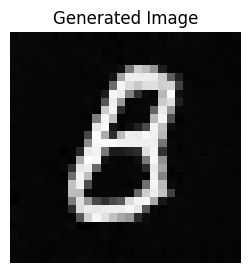

In [ ]:
generated = generate_image()

# Display the generated image
plt.figure(figsize=(3,3))
plt.imshow(generated[0,...,0], cmap='gray')
plt.axis('off')
plt.title("Generated Image")
plt.show()

While the denoised digit is recognizable as an “8,” the reconstruction still shows some imperfections. This suggests that there is room to improve the model or explore alternative approaches (e.g., different architectures, hyperparameters, or diffusion schedules) to achieve sharper, more detailed results.

---

6. Discussion:

What happens if we change the noise schedule?

- Answer:
Changing the noise schedule means adjusting how much noise is added at each diffusion step. A higher or more aggressive noise schedule can make the data harder to reconstruct, but it may also encourage the model to learn more robust features. Conversely, a slower or gentler noise schedule might make the training more stable but could lead to less diverse or lower-quality samples. Overall, the noise schedule controls the balance between stability in training and the richness of the generated outputs.

How do diffusion models compare to GANs?

- Answer:
Diffusion models and GANs are both powerful generative approaches but differ in their training strategies. Diffusion models gradually corrupt and then reconstruct data, which often leads to stable training and high-quality samples but can be slower during sampling. GANs, on the other hand, rely on an adversarial setup between a generator and a discriminator, which can be faster to sample from but sometimes suffer from instability issues like mode collapse. In practice, diffusion models are praised for their consistency and detail, while GANs are valued for their speed and flexibility.


---

Final Reflection
How does function inversion relate to diffusion models?

- Answer:
Function inversion in the context of diffusion models involves reversing the noise-adding process. During training, the model learns how data is corrupted step by step (the forward process). During sampling, the model “inverts” this function by removing noise iteratively, effectively reconstructing the original image from a noisy input. This reversal is key to generating new samples that match the distribution of the training data.

How does iterative noise removal help generate realistic images?

- Answer:
By gradually removing noise at each step, the model refines the image progressively. Early steps remove large-scale distortions, while later steps focus on subtle details. This staged denoising process allows the model to carefully reconstruct features, leading to crisp and coherent results. Each iteration uses the learned knowledge of the data distribution to guide the noise removal, producing more realistic images over time.

Potential applications of diffusion models (e.g., text-to-image generation like Stable
Diffusion)

- Answer:
Diffusion models are versatile and can be applied to a wide range of tasks. They excel in text-to-image generation, where they transform text prompts into high-quality images, as demonstrated by systems like Stable Diffusion. Beyond that, they can be used for image inpainting (filling in missing parts), super-resolution (enhancing image quality), and other creative applications such as style transfer or artistic image generation.